In [37]:
!pip install transformers datasets

In [75]:
import tensorflow as tf
from datasets import load_dataset
from transformers import DebertaTokenizerFast,DataCollatorWithPadding,TFDebertaForSequenceClassification,create_optimizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Data Preperation

In [38]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /content/kaggle.json
!kaggle datasets download -d bitext/training-dataset-for-chatbotsvirtual-assistants
!unzip "/content/training-dataset-for-chatbotsvirtual-assistants.zip" -d "/content/dataset/"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
training-dataset-for-chatbotsvirtual-assistants.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/training-dataset-for-chatbotsvirtual-assistants.zip
replace /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:
dataset = load_dataset("csv",
                       data_files="/content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent'],
        num_rows: 21534
    })
})

In [41]:
dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 'create_account'}

In [42]:
set(dataset['train']['intent'])

{'cancel_order',
 'change_order',
 'change_shipping_address',
 'check_cancellation_fee',
 'check_invoices',
 'check_payment_methods',
 'check_refund_policy',
 'complaint',
 'contact_customer_service',
 'contact_human_agent',
 'create_account',
 'delete_account',
 'delivery_options',
 'delivery_period',
 'edit_account',
 'get_invoice',
 'get_refund',
 'newsletter_subscription',
 'payment_issue',
 'place_order',
 'recover_password',
 'registration_problems',
 'review',
 'set_up_shipping_address',
 'switch_account',
 'track_order',
 'track_refund'}

In [43]:
intents = list(set(dataset['train']['intent']))

In [44]:
len(intents)

27

In [45]:
dict_intents={intents[i]: i for i in range(len(intents))}
print(dict_intents)
print(len(intents))

{'delivery_options': 0, 'change_shipping_address': 1, 'track_refund': 2, 'get_refund': 3, 'payment_issue': 4, 'delivery_period': 5, 'place_order': 6, 'registration_problems': 7, 'cancel_order': 8, 'edit_account': 9, 'track_order': 10, 'contact_customer_service': 11, 'change_order': 12, 'delete_account': 13, 'create_account': 14, 'review': 15, 'check_refund_policy': 16, 'contact_human_agent': 17, 'check_invoices': 18, 'recover_password': 19, 'check_cancellation_fee': 20, 'switch_account': 21, 'complaint': 22, 'newsletter_subscription': 23, 'set_up_shipping_address': 24, 'get_invoice': 25, 'check_payment_methods': 26}
27


In [46]:
def preprocess(dataset):
  return {'utterance':dataset['utterance'],
          'intent':dict_intents[dataset['intent']]}

In [47]:
prep_dataset = dataset.map(preprocess)

In [48]:
prep_dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 14}

In [49]:
model_id = "microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id)

In [50]:
def tokenizer_function(dataset):
  return tokenizer(dataset['utterance'])

In [51]:
tokenized_dataset = prep_dataset.map(tokenizer_function)

In [52]:
tokenized_dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 14,
 'input_ids': [1,
  100,
  218,
  75,
  33,
  41,
  804,
  1316,
  6,
  99,
  109,
  38,
  33,
  7,
  109,
  7,
  5124,
  116,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [53]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21534
    })
})

In [54]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [55]:
BATCH_SIZE = 16

In [56]:
tf_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'intent'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

In [57]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['intent']

In [58]:
tf_dataset = tf_dataset.map(swap_positions)

In [59]:
train_dataset=tf_dataset.take(int(0.9*len(tf_dataset)))
val_dataset=tf_dataset.skip(int(0.9*len(tf_dataset)))

In [60]:
for i in train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(16, 19), dtype=int64, numpy=
array([[    1, 37111,     6,    64,    47,  1394,    41,  2936,   147,
            7,  6296,     9,  3207,  1272,   116,     2,     0,     0,
            0],
       [    1,  7424,    38,   192,     5,  1735,    13,  2996,   116,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    1,   100,   240,   244, 14999,  1437,    41, 38199,     2,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    1,   100,   685,   127, 14844,     6,    99,   109,    38,
           33,     7,   109,     7,  5312,    24,   116,     2,     0,
            0],
       [    1,   100,   399,    75,  1325,   127,  4033,     6,   141,
           64,    38,   192,   106,   116,     2,     0,     0,     0,
            0],
       [    1,  5410,  1722,   109,    38,  1649,   127, 21782,   116,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
     

# Modeling

## TFDebertaForSequenceClassification

In [61]:
model = TFDebertaForSequenceClassification.from_pretrained(model_id,num_labels=len(intents))

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
model.summary()

Model: "tf_deberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLaye  multiple                  138601728 
 r)                                                              
                                                                 
 pooler (TFDebertaContextPo  multiple                  590592    
 oler)                                                           
                                                                 
 cls_dropout (TFDebertaStab  multiple                  0         
 leDropout)                                                      
                                                                 
 classifier (Dense)          multiple                  20763     
                                                                 
Total params: 139213083 (531.06 MB)
Trainable params: 139213083 (531.06 MB)
Non-trainable pa

In [63]:
num_epochs = 2
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [64]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [65]:
model.compile(optimizer=optimizer,
              metrics=['accuracy'])

In [66]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs=3)

Epoch 1/3
1211/1211 [==============================] - 430s 278ms/step - loss: 0.2263 - accuracy: 0.9506 - val_loss: 0.0050 - val_accuracy: 0.9995
Epoch 2/3
1211/1211 [==============================] - 254s 210ms/step - loss: 0.0066 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/3
1211/1211 [==============================] - 252s 208ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 1.0000


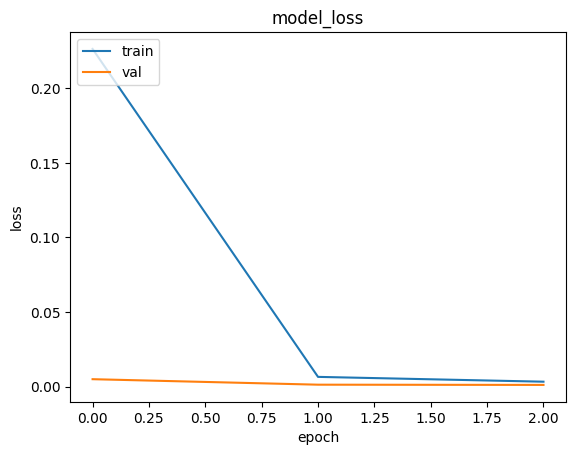

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

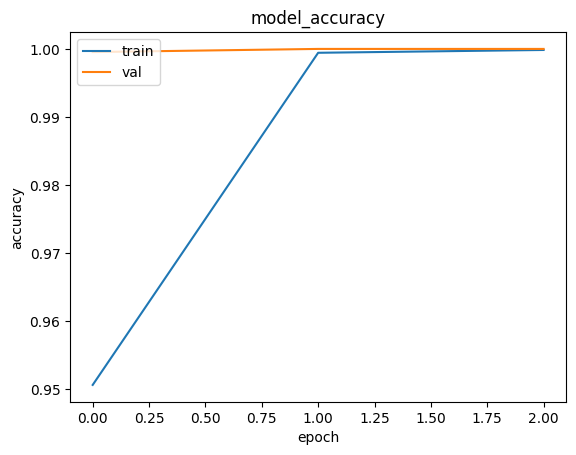

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [69]:
predicted = []
labels = []

for input, label in val_dataset:
  predicted.append(model(**input).logits)
  labels.append(label.numpy())

In [70]:
print(predicted)
print(labels)

[<tf.Tensor: shape=(16, 27), dtype=float32, numpy=
array([[-6.20370984e-01, -1.48323476e+00, -4.10984784e-01,
        -3.75271857e-01,  2.43772000e-01, -1.06538415e+00,
         3.42408158e-02, -1.79734027e+00, -1.62430775e+00,
        -1.33919179e+00, -6.05976760e-01, -8.50121200e-01,
        -7.75196791e-01, -1.80125415e+00, -1.07610136e-01,
        -2.06607670e-01, -1.35619247e+00, -4.50281680e-01,
         3.39891851e-01, -1.41869903e+00, -4.74603236e-01,
        -1.25728667e+00, -9.42418337e-01, -1.19344056e-01,
        -2.86772847e-01,  9.84568977e+00, -6.49219692e-01],
       [-1.47587883e+00, -9.38798547e-01, -1.07948504e-01,
        -1.16135752e+00, -1.45577359e+00, -1.07933307e+00,
        -1.78392088e+00, -1.18441880e+00, -7.10345730e-02,
         1.52307421e-01, -1.36350784e-02,  2.73543537e-01,
        -9.00507867e-01,  9.43306255e+00, -6.24055564e-01,
        -5.78637242e-01, -1.03881061e+00, -1.11145175e+00,
        -3.34759444e-01,  3.90814722e-01, -7.85922647e-01,
    

In [71]:
print(tf.argmax(predicted[:-1],axis=-1).numpy())
print(labels[:-1])

[[25 13 10 ...  4 22 10]
 [25  4 17 ... 18 25 14]
 [25 17  4 ... 17 25 17]
 ...
 [11  4 17 ... 17 23 16]
 [25  4  4 ... 19 23 17]
 [ 3 25 20 ... 11 12  3]]
[array([25, 13, 10,  3,  3, 18, 13, 18, 13,  4, 17, 25, 15,  4, 22, 10]), array([25,  4, 17,  4, 15, 10, 25, 14, 18, 25, 14, 17, 11, 18, 25, 14]), array([25, 17,  4, 11, 10,  4, 25, 25, 10, 12, 11, 25,  1, 17, 25, 17]), array([14, 10,  4, 11,  7, 15,  4, 15, 12, 22,  4, 11, 23,  4, 18, 14]), array([14,  2, 14, 11,  4, 10, 11, 18,  3, 11,  4, 11, 15, 13, 25, 14]), array([10,  3,  5, 22,  4, 14, 23,  4,  3, 11, 11, 19, 22,  4,  4,  4]), array([11,  4,  4, 26,  4,  0, 14, 19, 25, 11, 16, 11,  4, 17, 11, 26]), array([25,  3,  4, 18, 17, 18, 22, 19,  3, 20, 26, 22, 12,  4, 14, 15]), array([ 4,  3,  3, 11, 19, 12, 12,  5, 23, 11, 15, 10,  4, 10, 15,  5]), array([25, 19, 14, 14, 12,  2,  4, 25, 18,  0, 10,  4, 14,  4, 26, 18]), array([15, 10, 10, 17, 25, 12,  4,  4, 10, 10, 15,  4, 11,  3, 19,  4]), array([25, 17, 17, 11,  4, 11,  3,  7,  

In [76]:
print(np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[25 13 10 ... 25 16 21]
[25 13 10 ... 25 16 21]


In [77]:
pred=np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()])
lab=np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[ 48   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0  17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0  28   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0 114   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 426   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  11   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   7   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  14   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 

Text(0.5, 146.7222222222222, 'Predicted')

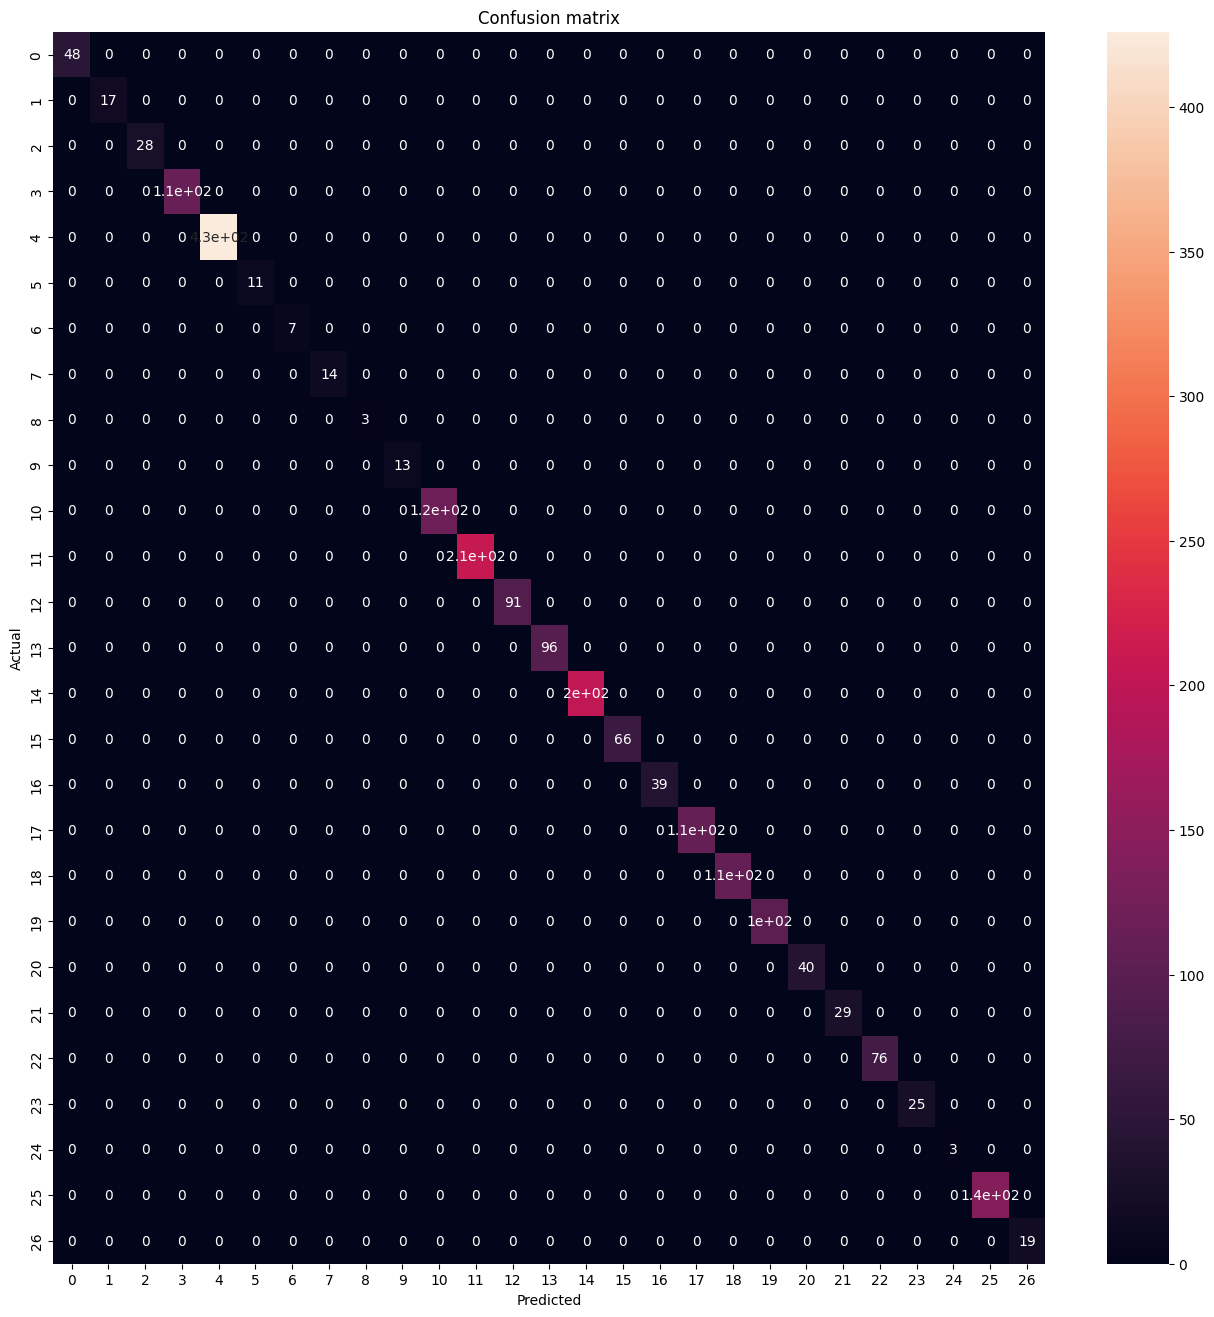

In [78]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(16,16))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Testing

In [79]:
inputs = tokenizer(["Please how do i go about the account creation? ",
                    "After setting up my account, i feel like i need to change it. How do i go about that?",
                    "how do i know how much i need to pay?",
                    "purchased a product, which i now want to change"
                    ], padding=True,return_tensors="tf")

logits = model(**inputs).logits
outputs=tf.argmax(logits,axis=-1).numpy()

In [80]:
outputs

array([14, 13, 26, 12])

In [81]:
reverse_dict_intents={i:intents[i] for i in range(len(intents))}
print(reverse_dict_intents)

{0: 'delivery_options', 1: 'change_shipping_address', 2: 'track_refund', 3: 'get_refund', 4: 'payment_issue', 5: 'delivery_period', 6: 'place_order', 7: 'registration_problems', 8: 'cancel_order', 9: 'edit_account', 10: 'track_order', 11: 'contact_customer_service', 12: 'change_order', 13: 'delete_account', 14: 'create_account', 15: 'review', 16: 'check_refund_policy', 17: 'contact_human_agent', 18: 'check_invoices', 19: 'recover_password', 20: 'check_cancellation_fee', 21: 'switch_account', 22: 'complaint', 23: 'newsletter_subscription', 24: 'set_up_shipping_address', 25: 'get_invoice', 26: 'check_payment_methods'}


In [82]:
for i in outputs:
  print(reverse_dict_intents[i])

create_account
delete_account
check_payment_methods
change_order
